# Installing required libraries


In [6]:
!pip -q install pandas
!pip -q install imutils
!pip -q install matplotlib
!pip -q install numpy
!pip -q install opencv-python
!pip -q install scikit-learn



You should consider upgrading via the 'C:\Users\C2IN\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\C2IN\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\C2IN\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\C2IN\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\C2IN\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\C2IN\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


# Headers


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2
from numpy import linalg
import imutils
import pandas as pd
from sklearn.model_selection import train_test_split
import random
from time import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import normalize
from sklearn import decomposition

from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline

# Detection of the faces

In [10]:
import cv2
import os
j =1

detected_faces=[]
def faces_extraction(i):
    global j
    global detected_faces
    image = cv2.imread('dataset/image_' + str(i+1).zfill(4)+'.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade= cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(image,1.3,5,minSize=(200, 200))

    for (x, y, k, l) in faces:
        img = image[y:y+l,x:x+k]
        mod_size = cv2.resize(img, (200, 200))
        name = 'Recognized_faces/face' + str(j).zfill(4) + '.jpg'
        j+=1 #index of the detected images
        detected_faces.append(mod_size)
        cv2.imwrite(name, mod_size)
       
        break
        
j=1
for i in range(450):
    faces_extraction(i)

print("Done detection")

Done detection


#  test and train


In [11]:
faces_detect = pd.read_csv('data.csv')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    detected_faces, list(faces_detect["Person"]), test_size=0.2, random_state=42
)

In [13]:
img_dim = X_train[6].shape
print(img_dim)

(200, 200)


In [14]:
One_dim=[]
for ele in X_train:
        each = ele.flatten()
        One_dim.append(each)
        
sizeOf_train = len(One_dim)
One_dim = np.array(One_dim)
print(One_dim.shape)

(342, 40000)


# Matrix operations

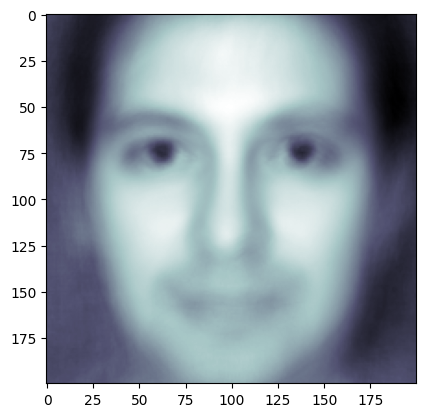

In [32]:
shape_One_dim = One_dim[0].shape
average = np.zeros(shape_One_dim)
for k in range(sizeOf_train):
    average =  average + One_dim[k]/sizeOf_train
    

average_img = np.reshape(average, img_dim)

plt.imshow(average_img, cmap="bone")
plt.show()

In [34]:
deviation = []
for ele in One_dim:
    deviation.append(ele-average)


deviation = np.array(deviation)

print(deviation.shape)
deviation= deviation.T
cov_mat = np.matmul(deviation.T, deviation)
print(cov_mat.shape)

Eigen_val, Eigen_vec = linalg.eig(cov_mat)
idx = Eigen_val.argsort()[::-1]   
Eigen_val = Eigen_val[idx]
Eigen_vec = Eigen_vec[:,idx]

(342, 40000)
(342, 342)


In [35]:

from sklearn.preprocessing import normalize
k = 39
k_eig_vec = [Eigen_vec[:, i] for i in range(k)]
k_eig_faces = [np.matmul(deviation, i) for i in k_eig_vec]
k_eig_faces = [j/linalg.norm(j) for j in k_eig_faces]

deviation.shape

(40000, 342)

# Choose k = 39

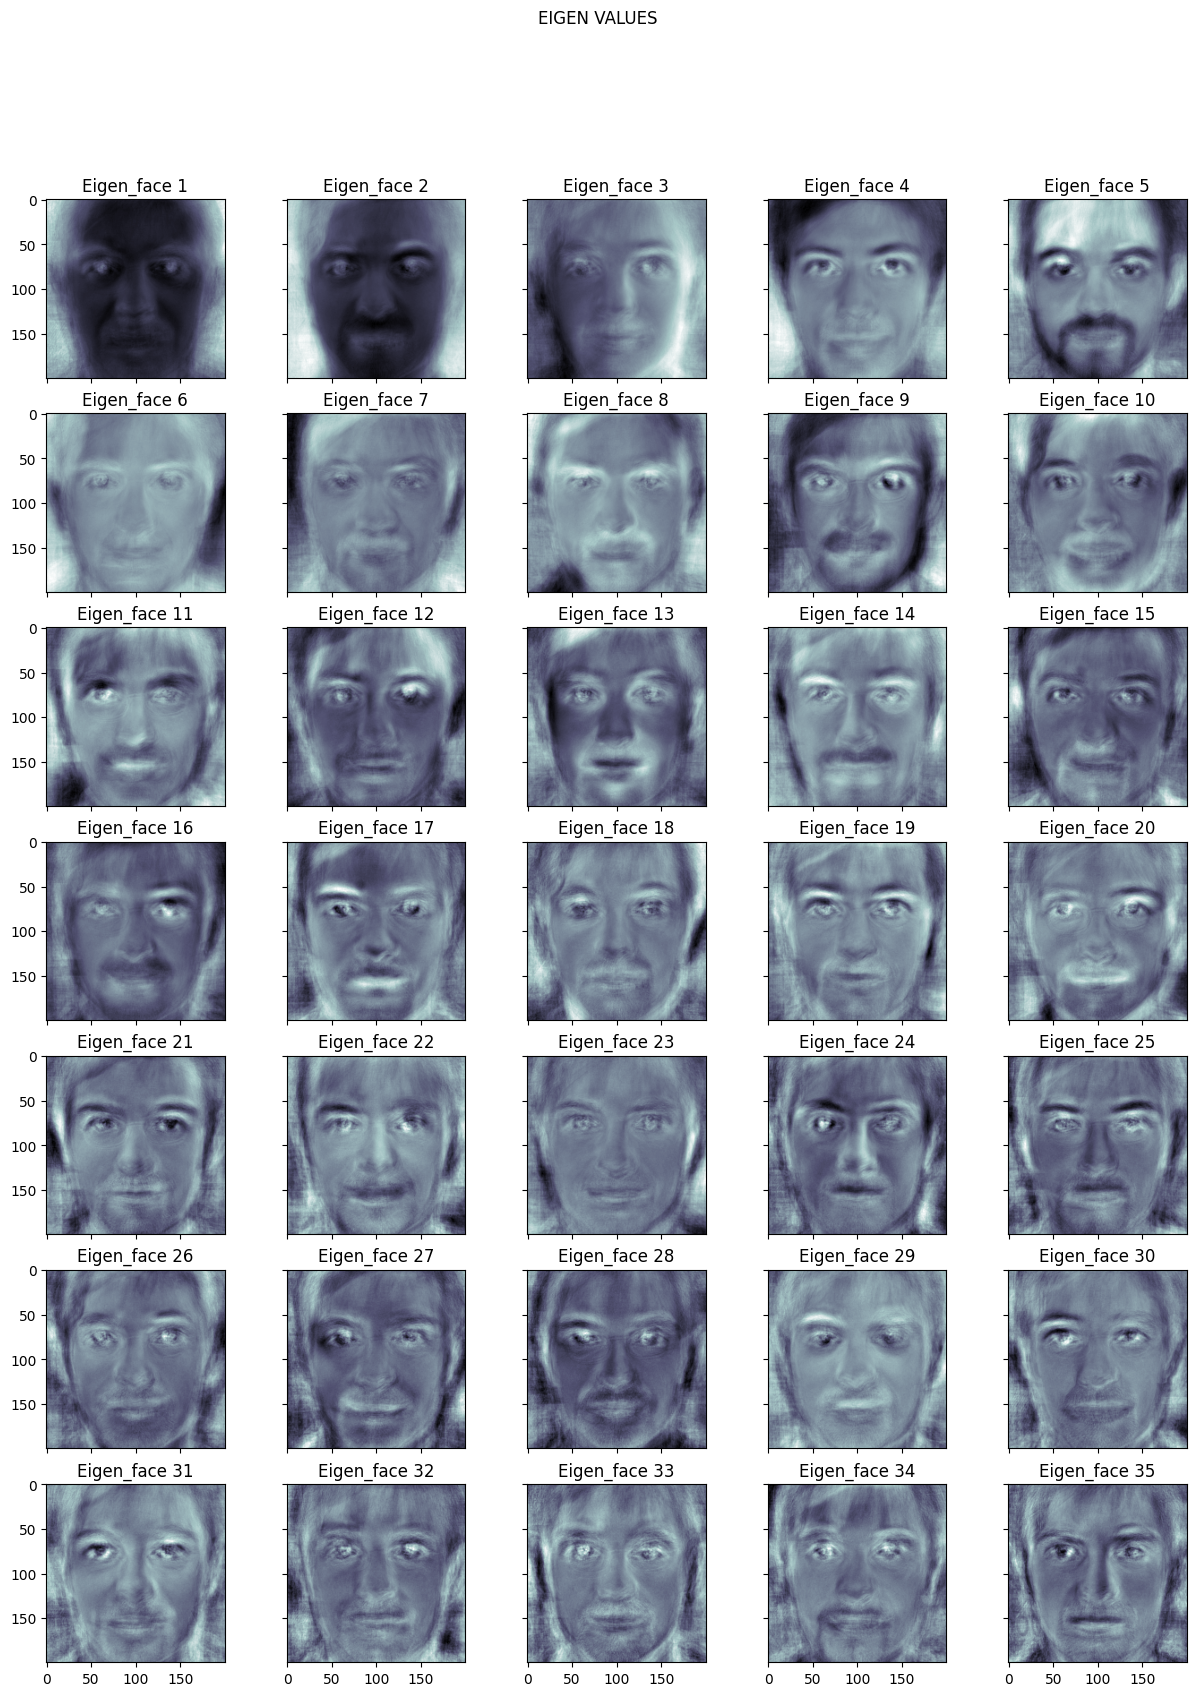

In [37]:
fig, axes = plt.subplots(k//5, 5, sharex=True,sharey=True,figsize=(15, k//2))
fig.suptitle("EIGEN VALUES")
for i, ax in enumerate(axes.flat):
    ax.set_title("Eigen_face "+str(i+1))
    ax.imshow(np.reshape(k_eig_faces[i], img_dim), cmap="bone")
plt.show()

# Random image

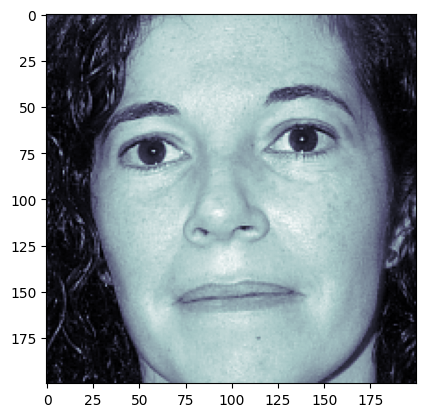

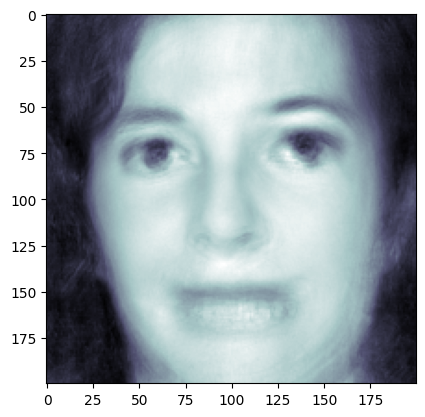

In [38]:
Randomface = X_test[random.randint(0, len(X_test))].flatten()
Randomface_img = np.reshape(Randomface, img_dim)
plt.imshow(Randomface_img, cmap="bone")
plt.show()

Normalized = Randomface - average
z = np.dot(np.array(k_eig_faces), Normalized.T)
img_face_space = sum([k_eig_faces[i]*z[i]   for i in range(k)]) 
face_sum_img = np.reshape(img_face_space, img_dim)

plt.imshow(face_sum_img+average_img, cmap="bone")

plt.show()

In [39]:
from sklearn import decomposition
k = 39
pca = decomposition.PCA(n_components=k, whiten=True)
pca.fit(np.array(One_dim))

PCA(n_components=39, whiten=True)

In [40]:
Wt_train_imgs = []
Wt_test_imgs = []


for val, f in enumerate(X_train):
    Normalized = f.flatten() - average
    z = np.dot(np.array(pca.components_), Normalized.T)
    Wt_train_imgs.append(z)

for val, f in enumerate(X_test):
    Normalized = f.flatten() - average
    z = np.dot(np.array(pca.components_), Normalized.T)
    Wt_test_imgs.append(z)
    
#print(len(Wt_train_imgs))
#print(len(Wt_test_imgs))

# Test image prediction

In [41]:
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")


Wt_train_imgs = [i.tolist() for i in Wt_train_imgs]
Wt_test_imgs = [i.tolist() for i in Wt_test_imgs]

clf = svm.SVC(C=28, kernel="linear")
clf.fit(Wt_train_imgs, y_train)


SVC(C=28, kernel='linear')

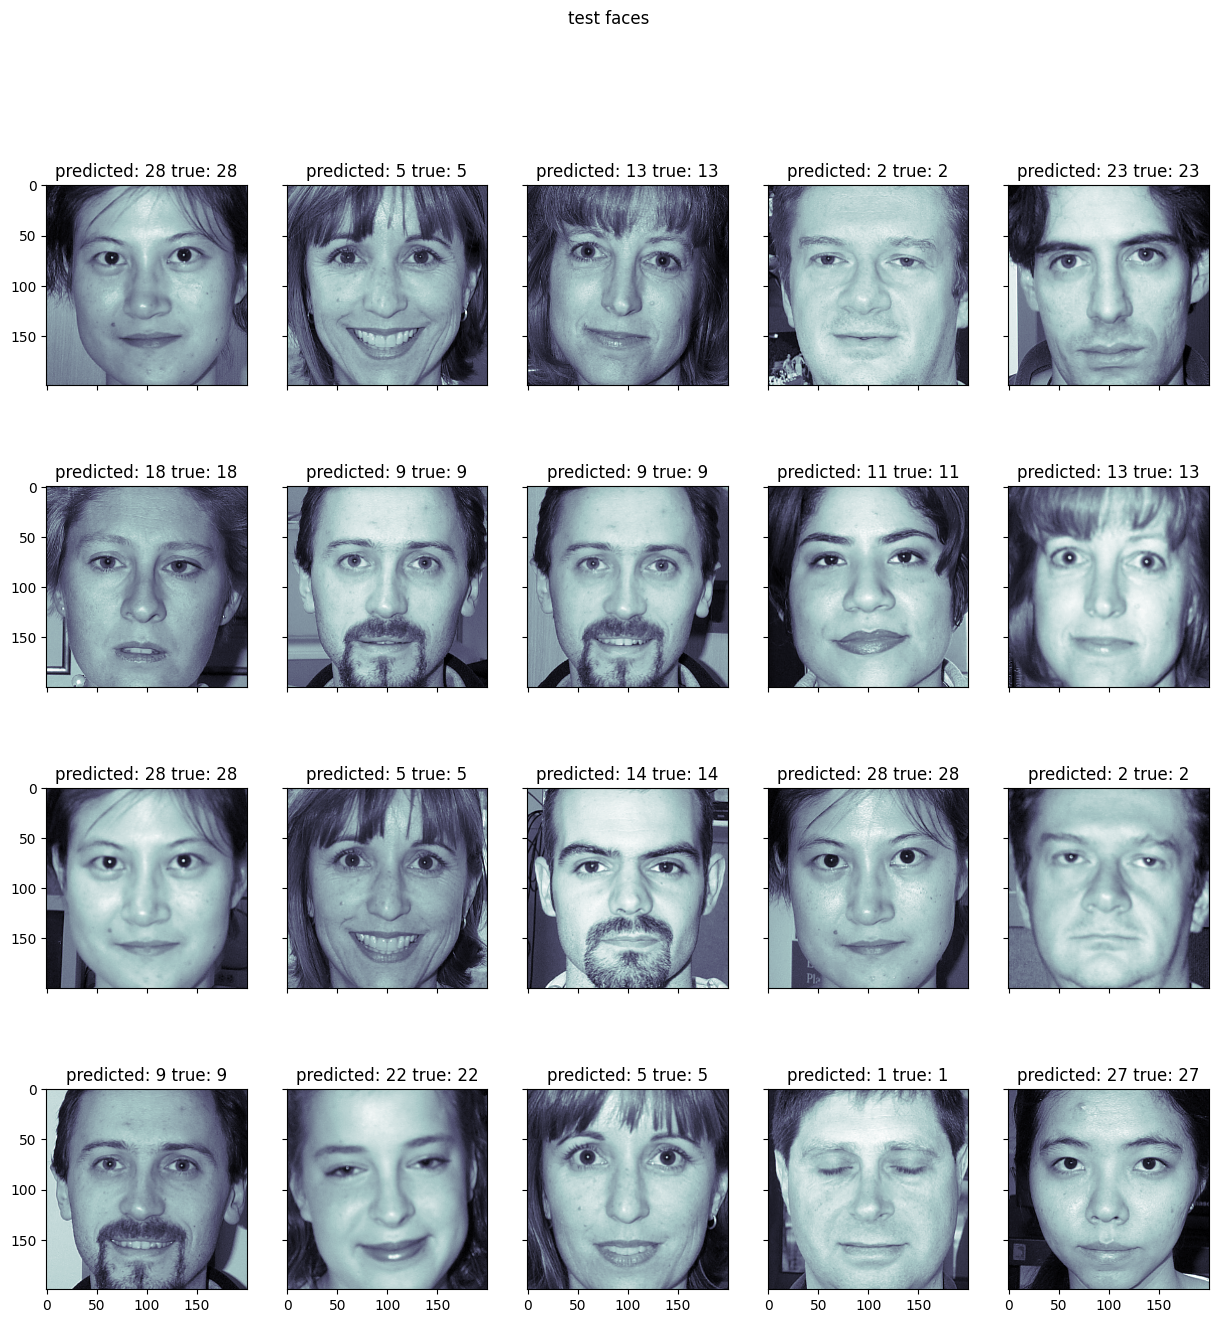

In [23]:
#Prediction

truevals = y_test[:20]
prediction = clf.predict(Wt_test_imgs[:20])

fig, axes = plt.subplots(4, 5, sharex=True,sharey=True,figsize=(15, 15))
fig.suptitle("test faces")
for i, ax in enumerate(axes.flat):
    ax.set_title("predicted: "+str(prediction[i])+" "+"true: "+ str(truevals[i]))
    ax.imshow(X_test[i], cmap="bone")
plt.show()

# Evaluation of wt_train_imgs and wt_test_img:

In [24]:
from sklearn import metrics

prediction = clf.predict(Wt_train_imgs)
print(classification_report(y_train, prediction))
print("Accuracy attained:",metrics.accuracy_score(y_train, prediction))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00        18
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00        19
           7       1.00      1.00      1.00        16
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00        12
          14       1.00      1.00      1.00        15
          15       1.00      1.00      1.00        23
          16       1.00      1.00      1.00        21
          17       1.00      1.00      1.00         4
          18       1.00    

In [25]:
from sklearn import metrics

prediction = clf.predict(Wt_test_imgs)
print(classification_report(y_test, prediction))
print("Accuracy attained:",metrics.accuracy_score(y_test, prediction))

              precision    recall  f1-score   support

           1       1.00      0.80      0.89         5
           2       0.86      1.00      0.92         6
           3       0.00      0.00      0.00         1
           4       1.00      0.75      0.86         4
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          18       1.00      1.00      1.00         5
          19       1.00      1.00      1.00         3
          20       0.00      0.00      0.00         0
          21       1.00      1.00      1.00         2
          22       0.50    